# Noisy student POC

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
import cv2
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image

plt.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
from pathlib import Path
SAMPLE_SIZE = 100
BASE_DIR = Path('../')
DATASETS_PATH = BASE_DIR.joinpath('datasets')
DATASET_NAME = 'coco'
COCO_DATASET_PATH = DATASETS_PATH.joinpath(DATASET_NAME)
COCO_VAL_PATH = COCO_DATASET_PATH.joinpath('val2017')
RESNET101_MODEL = ('http://github.com/vita-epfl/openpifpaf-torchhub/releases/download/'
                   'v0.10.0/resnet101block5-pif-paf-paf25-edge401-191012-132602-a2bf7ecd.pkl')
IMAGE_EXT = '.jpg'

In [3]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocotools import coco

# initialize COCO api for person keypoints annotations
annFile = COCO_DATASET_PATH.joinpath('annotations/annotations_trainval2017/annotations/person_keypoints_val2017.json')
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [4]:
# get all images containing given categories, select one at random
catIds = coco_kps.getCatIds(catNms=['person']);
imgIds = coco_kps.getImgIds(catIds=catIds );
imgIds = coco_kps.getImgIds(imgIds = [324158])
img = coco_kps.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [5]:
catIds = coco_kps.getCatIds(['person'])
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco_kps.loadAnns(annIds)

In [6]:
anns

[{'segmentation': [[228.43,
    247.9,
    229.63,
    206.62,
    224.24,
    191.07,
    220.65,
    179.7,
    207.49,
    169.53,
    202.71,
    163.55,
    205.7,
    133.04,
    218.86,
    121.68,
    213.47,
    104.33,
    225.44,
    96.55,
    236.8,
    106.12,
    236.8,
    116.29,
    254.15,
    127.06,
    263.72,
    150.39,
    274.49,
    166.54,
    271.5,
    177.31,
    266.12,
    181.5,
    257.14,
    159.96,
    254.75,
    177.91,
    261.93,
    192.27,
    262.53,
    216.79,
    261.33,
    234.14,
    268.51,
    249.1,
    247.57,
    246.11,
    245.78,
    249.69,
    229.03,
    248.5]],
  'num_keypoints': 12,
  'area': 5999.5445,
  'iscrowd': 0,
  'keypoints': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   212,
   135,
   2,
   241,
   125,
   2,
   209,
   162,
   2,
   257,
   146,
   2,
   218,
   172,
   2,
   267,
   167,
   2,
   225,
   177,
   2,
   247,
   176,
   2,
   235,
   203,
   2,
   254,

In [7]:
import skimage.io as io

def plot_img_and_ann(img):
    I = io.imread(img['coco_url'])
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(I)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(I)
    catIds = coco_kps.getCatIds(['person'])
    annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds)
    anns = coco_kps.loadAnns(annIds)
    coco_kps.showAnns(anns)
    plt.tight_layout()

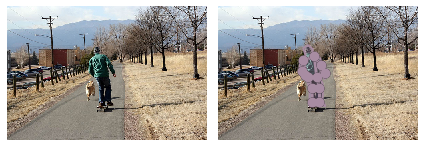

In [8]:
plot_img_and_ann(img)

In [9]:
from torchvision.datasets import CocoDetection
from torchvision import transforms

batch_size=1

transform = transforms.Compose([
    # If i set batch_size to more than 1 than i need to resize all the images to the same size 
    transforms.ToTensor()
])

coco_person_val_ds = CocoDetection(root = COCO_VAL_PATH,
                                    annFile = annFile,
                                    transform=transform)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


In [10]:
coco_person_val_loader = DataLoader(dataset=coco_person_val_ds, batch_size=batch_size, shuffle=True)

In [11]:
import openpifpaf

print(openpifpaf.__version__)

0.10.1


In [12]:
net_cpu, _ = openpifpaf.network.factory(checkpoint='resnet101')

/home/ma/.local/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ma/.local/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'openpifpaf.network.basenetworks.BaseNetwork' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ma/.local/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object

In [13]:
if torch.cuda.is_available():
    net = net_cpu.cuda()
else:
    net = net_cpu
decode = openpifpaf.decoder.factory_decode(net, 
                                           seed_threshold=0.5)
processor = openpifpaf.decoder.Processor(net, decode, 
                                         instance_threshold=0.2,
                                         keypoint_threshold=0.3)

In [14]:
dir(processor.annotations)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [15]:
import PIL
import requests
import io 

image_response = requests.get('https://raw.githubusercontent.com/vita-epfl/openpifpaf/master/docs/coco/000000081988.jpg')
pil_im = PIL.Image.open(io.BytesIO(image_response.content)).convert('RGB')
im = np.asarray(pil_im)

In [16]:
from torchvision import transforms

batch_size=1

transform = transforms.Compose([
    # If i set batch_size to more than 1 than i need to resize all the images to the same size 
    transforms.ToTensor()
])

coco_person_val_ds = CocoDetection(root = COCO_VAL_PATH,
                                    annFile = annFile,
                                    transform=transform)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [17]:
def gen_plot():
    import io
    """Create a pyplot plot and save to buffer."""
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return buf

In [18]:
from torch.utils.tensorboard import SummaryWriter
import datetime

log_dir = "logs/eval/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Write logs to 'logs' dir
writer = SummaryWriter(log_dir)

/home/ma/.local/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'openpifpaf.network.nets.Shell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ma/.local/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'openpifpaf.network.basenetworks.BaseNetwork' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ma/.local/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object

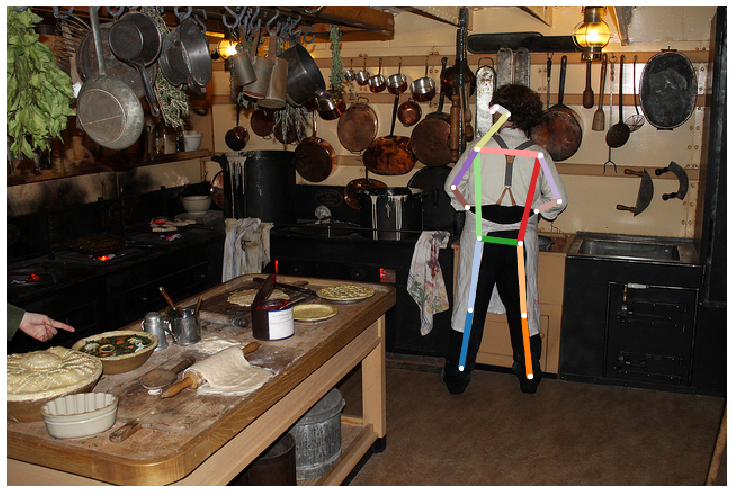

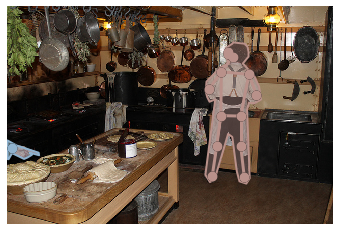

In [24]:
import openpifpaf
import os 

net_cpu, _ = openpifpaf.network.factory(checkpoint='resnet101')
if torch.cuda.is_available():
    net = net_cpu.cuda()
    device = torch.device('cuda:0')
else:
    net = net_cpu
    device = torch.device('cpu:0')
decode = openpifpaf.decoder.factory_decode(net, 
                                           seed_threshold=0.5)
processor = openpifpaf.decoder.Processor(net, decode, 
                                         instance_threshold=0.2,
                                         keypoint_threshold=0.3)


loader = torch.utils.data.DataLoader(coco_person_val_ds, batch_size=1, pin_memory=True)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=6)

for i, (images_batch, ann_ids) in enumerate(loader):
    images_batch = images_batch.to(device)
    fields_batch = processor.fields(images_batch)
    predictions = processor.annotations(fields_batch[0])

    im_arr = np.array(images_batch[0].cpu().permute(1,2,0))
    with openpifpaf.show.image_canvas(im_arr) as ax:
        keypoint_painter.annotations(ax, predictions)
        plot_buf = gen_plot()
        image = Image.open(plot_buf)
        pred_image = transforms.ToTensor()(image).unsqueeze(0)
        writer.add_image(f'prediction_{i}', pred_image[0])
        # keypoint_painter.keypoints(ax,predictions, target)
    plt.axis('off')
    plt.imshow(im_arr)
    ann_ids_list = [id.item() for id in ann_ids]
    target = coco_kps.loadAnns(ann_ids_list)
    coco_kps.showAnns(target)
    plot_buf = gen_plot()
    image = Image.open(plot_buf)
    label_image = transforms.ToTensor()(image).unsqueeze(0)
    writer.add_image(f'prediction_label_{i}', label_image[0])
    break
    if i==10:
        break

import openpifpaf
import os 

net_cpu, _ = openpifpaf.network.factory(checkpoint='resnet101')
if torch.cuda.is_available():
    net = net_cpu.cuda()
    device = torch.device('cuda:0')
else:
    net = net_cpu
    device = torch.device('cpu:0')
decode = openpifpaf.decoder.factory_decode(net, 
                                           seed_threshold=0.5)
processor = openpifpaf.decoder.Processor(net, decode, 
                                         instance_threshold=0.2,
                                         keypoint_threshold=0.3)


loader = torch.utils.data.DataLoader(coco_person_val_ds, batch_size=1, pin_memory=True)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=6)

for images_batch, ann_ids in loader:
    images_batch = images_batch.to(device)
    fields_batch = processor.fields(images_batch)
    predictions = processor.annotations(fields_batch[0])

    im_arr = np.array(images_batch[0].cpu().permute(1,2,0))
    plt.subplot(1,2,1)
    with openpifpaf.show.image_canvas(im_arr) as ax:
        keypoint_painter.annotations(ax, predictions)
        # keypoint_painter.keypoints(ax,predictions, target)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(im_arr)
    ann_ids_list = [id.item() for id in ann_ids]
    target = coco_kps.loadAnns(ann_ids_list)
    coco_kps.showAnns(target)
    plt.tight_layout()
    
    

import openpifpaf

net_cpu, _ = openpifpaf.network.factory(checkpoint='resnet101')
if torch.cuda.is_available():
    net = net_cpu.cuda()
else:
    net = netm_cpu
decode = openpifpaf.decoder.factory_decode(net, 
                                           seed_threshold=0.5)
processor = openpifpaf.decoder.Processor(net, decode, 
                                         instance_threshold=0.2,
                                         keypoint_threshold=0.3)


# data = openpifpaf.datasets.PilImageList([pil_im])
loader = torch.utils.data.DataLoader(coco_person_val_ds, batch_size=1, pin_memory=True)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=6)

for images_batch, labels in loader:
    fields_batch = processor.fields(images_batch)
    predictions = processor.annotations(fields_batch[0])
    print(labels)
    print(predictions[0])
    im_arr = np.array(images_batch[0].permute(1,2,0))
    with openpifpaf.show.image_canvas(im_arr) as ax:
        keypoint_painter.annotations(ax, predictions)

    plt.axis('off')
    plt.imshow(im_arr)
    coco_kps.showAnns(anns)
    plt.tight_layout()
    break

In [25]:
epochs=2

def val_pifpaf(val_loader, model, criterion, optimizer):
    if torch.cuda.is_available():
        model.cuda()
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu:0')
    model.eval()
    val_loss = 0
#     for epoch in range(epochs):
    with torch.no_grad():
        for step, batch in enumerate(val_loader):
            imgs, labels = batch
            imgs = imgs.to(device, dtype=torch.float)
#             labels = labels.to(device, dtype=torch.float)
            outputs = model(imgs)
            fields_batch = processor.fields(outputs)
            predictions = processor.annotations(fields_batch[0])
            # Adjust the image for imshow format(Channels at the end)
            print(predictions)
            with openpifpaf.show.image_canvas(np.array(outputs[0].permute(1, 2, 0))) as ax:
                keypoint_painter.annotations(ax, predictions)
            break
                
    #             loss = criterion(outputs, labels)
    #             val_loss += loss.item()
    #             for i in range(batch_size):
    #                 writer.add_image(f'eval_image_{i + step * batch_size}', outputs[i])
#         writer.add_scalar('validation_loss', val_loss, epoch)